### create figure for hierarchy example
1. get latent distances vs sequential distances
2. get MI of markov model
3. get MI of recursively generated sequence - store the average latent distance for each of the sequential distances
4. Plot latent distance by MI
5. plot sequential distance by MI

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

#### Make an example tree

In [3]:
r = 3 # branching factor
h = 3 # height
btree = nx.balanced_tree(r=r,h=h)
n_final_nodes = r**h

In [4]:
list(btree.nodes)[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [5]:
list(btree.edges)[:10]

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 10)]

In [6]:
nx.shortest_path(btree, 0, 27)

[0, 2, 8, 27]

In [7]:
pos=nx.drawing.nx_agraph.graphviz_layout(btree,prog='dot')
#pos[0] = (pos[0][0], pos[0][1]-32)

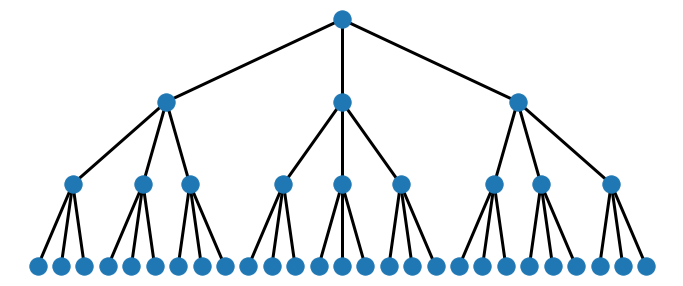

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
nx.draw(btree,pos,with_labels=False,arrows=False, width = 3, ax=ax)

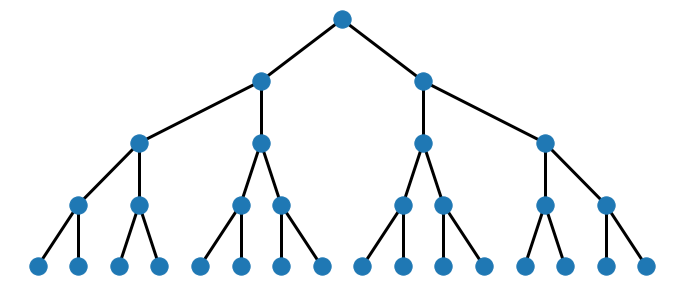

In [9]:
r = 2 # branching factor
h = 4 # height
btree = nx.balanced_tree(r=r,h=h)
n_final_nodes = r**h
pos=nx.drawing.nx_agraph.graphviz_layout(btree,prog='dot')
fig, ax = plt.subplots(figsize=(12,5))
nx.draw(btree,pos,with_labels=False,arrows=False, width = 3, ax=ax)

#### get distances between nodes

In [10]:
import pandas as pd
from tqdm.autonotebook import tqdm
from joblib import parallel_backend
from joblib import Parallel, delayed

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [11]:
loc_df = pd.DataFrame(pos).T
loc_df.columns = ['x', 'y']
loc_df[:3]

,x,y
0,567.0,306.0
1,423.0,234.0
2,711.0,234.0


In [12]:
r = 2 # branching factor
h = 10 # height
btree = nx.balanced_tree(r=r,h=h)
n_final_nodes = r**h

In [13]:
len(btree.nodes)

2047

In [14]:
lowest_level_nodes = list(list(btree.nodes)[-n_final_nodes:])
lowest_level_nodes
len(lowest_level_nodes)

1024

In [15]:
l = [
    [(node1, node2, n1 - n2) for n2, node2 in enumerate(lowest_level_nodes) if n2 < n1]
    for n1, node1 in enumerate(lowest_level_nodes)
]
pair_list = [item for sublist in l for item in sublist]
latent_vs_sequential_dist = pd.DataFrame(
    pair_list, columns=["node1", "node2", "sequential_distance"]
)
len(pair_list)

523776

In [16]:
with Parallel(n_jobs=1, prefer="threads") as parallel:
    latent_distances = [
        parallel(delayed(nx.shortest_path_length)(btree, row.node1, row.node2)
        for idx, row in tqdm(
            latent_vs_sequential_dist.iterrows(), total=len(latent_vs_sequential_dist)
        )
                )
    ]
latent_vs_sequential_dist['latent_distances'] = latent_distances[0]

In [17]:
row = latent_vs_sequential_dist.iloc[0]

In [18]:
nx.shortest_path_length(btree, row.node1, row.node2)

2

In [19]:
latent_vs_sequential_dist[:3]

,node1,node2,sequential_distance,latent_distances
0,1024,1023,1,2
1,1025,1023,2,4
2,1025,1024,1,4


In [20]:
# summarize distances
dist_summary = latent_vs_sequential_dist.groupby(['sequential_distance']).agg(['mean', 'std'])
dist_summary[:3]

node1               node2             latent_distances  \
                       mean         std    mean         std             mean   
sequential_distance                                                            
1                    1535.0  295.458965  1534.0  295.458965         3.980450   
2                    1535.5  295.170290  1533.5  295.170290         5.964775   
3                    1536.0  294.881615  1533.0  294.881615         6.950049   

                               
                          std  
sequential_distance            
1                    2.759720  
2                    2.715128  
3                    2.856443

In [21]:
# fit logarithmic growth model

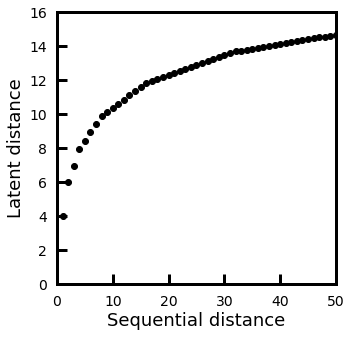

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(dist_summary.index.values, dist_summary.latent_distances['mean'], color = 'k')
ax.set_xlim([0, 50])
ax.set_ylim([0, 16])
ax.set_xlabel('Sequential distance', fontsize=18)
ax.set_ylabel('Latent distance', fontsize=18)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)



In [23]:
import lmfit

def residuals(y_true, y_model, x, logscaled=False):
    if logscaled:
        return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))
    else:
        return np.abs(y_true - y_model)

def model_res(p, x, y, fit, model):
    if fit == "lin":
        return residuals(y, model(p, x), x)
    else:
        return residuals(y, model(p, x), x, logscaled=True)
    
# fitting model
def fit_model_iter(model, n_iter=10, **kwargs):
    """ re-fit model n_iter times and choose the best fit
    chooses method based upon best-fit
    """
    models = []
    AICs = []
    for iter in np.arange(n_iter):
        results_model = model.minimize(**kwargs)
        models.append(results_model)
        AICs.append(results_model.aic)
    return models[np.argmin(AICs)]

def get_y(model, results, x):
    return model({i: results.params[i].value for i in results.params}, x)

def exp_decay(p, x):
    return p["e_init"] * np.exp(-x * p["e_decay_const"]) + p["intercept"]

def log_growth(p, x):
    return p['a'] * np.log(p['b'] * x) + p['intercept']



# decay types
def powerlaw_decay(p, x):
    return p["p_init"] * x ** (p["p_decay_const"]) + p["intercept"]

p_log_growth = lmfit.Parameters()
p_log_growth.add_many(
    ("a", 2.5, True),
    ("b", 1, True),
    ("intercept", 1.0, True),
)

#### Fit log growth

In [24]:
fit='linear'
n_iter=1
method=["nelder", "leastsq", "least-squares"]

In [25]:
d = dist_summary.index.values[:50]
sig = dist_summary.latent_distances['mean'][:50]

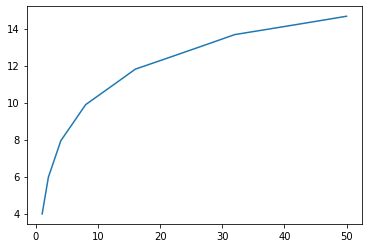

In [26]:
plt.plot(d, sig)

In [27]:
results_lg_min = lmfit.Minimizer(
    model_res, p_log_growth, fcn_args=(d, sig, fit, log_growth), nan_policy="omit"
)
results_lg = fit_model_iter(results_lg_min, n_iter=n_iter, **{"method": 'nelder'})
#y_lg = log_growth(p={'a':5,'b':0.5, 'intercept':1.0}, x=d)
d = np.arange(51)
y_lg = get_y(log_growth, results_lg, d)
print(results_lg.params)

Parameters([('a', <Parameter 'a', 2.7698218212547148, bounds=[-inf:inf]>), ('b', <Parameter 'b', 2.2503003322456503, bounds=[-inf:inf]>), ('intercept', <Parameter 'intercept', 1.7418769260381528, bounds=[-inf:inf]>)])


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


In [33]:
FIGURE_DIR

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/figures')

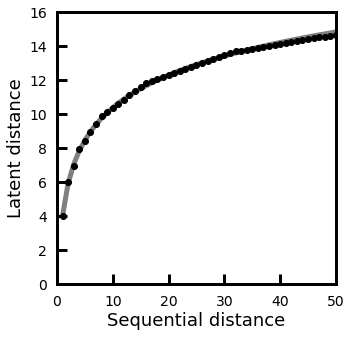

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(dist_summary.index.values, dist_summary.latent_distances['mean'], color = 'k')
ax.plot(d, y_lg, alpha = 0.5, color= 'k', lw=5)

ax.set_xlim([0, 50])
ax.set_ylim([0, 16])
ax.set_xlabel('Sequential distance', fontsize=18)
ax.set_ylabel('Latent distance', fontsize=18)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)

ensure_dir(FIGURE_DIR/'model_fig')
save_fig(FIGURE_DIR/ 'model_fig' / 'latent-sequential-distance')

In [29]:
### look at latent growth

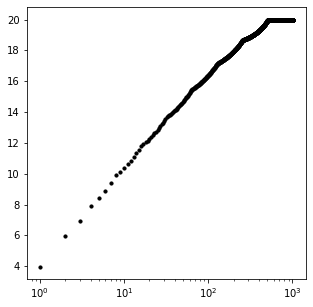

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(dist_summary.index.values, dist_summary.latent_distances['mean'], s=10, color = 'k')
ax.set_xscale('log')
#ax.set_xlim([1,50])
#ax.set_ylim([0, 16])

In [31]:
dist_summary.to_pickle('latent_vs_sequential_distance.pickle')

In [32]:
dist_summary

node1               node2             latent_distances  \
                       mean         std    mean         std             mean   
sequential_distance                                                            
1                    1535.0  295.458965  1534.0  295.458965         3.980450   
2                    1535.5  295.170290  1533.5  295.170290         5.964775   
3                    1536.0  294.881615  1533.0  294.881615         6.950049   
4                    1536.5  294.592939  1532.5  294.592939         7.937255   
5                    1537.0  294.304264  1532.0  294.304264         8.423945   
...                     ...         ...     ...         ...              ...   
1019                 2044.0    1.581139  1025.0    1.581139        20.000000   
1020                 2044.5    1.290994  1024.5    1.290994        20.000000   
1021                 2045.0    1.000000  1024.0    1.000000        20.000000   
1022                 2045.5    0.707107  1023.5    0.707107        20.000000   
1023                 2046.0         NaN  1023.0         NaN        20.000000   

                               
                          std  
sequential_distance            
1                    2.759720  
2                    2.715128  
3                    2.856443  
4                    2.645563  
5                    2.752540  
...                       ...  
1019                 0.000000  
1020                 0.000000  
1021                 0.000000  
1022                 0.000000  
1023                      NaN  

[1023 rows x 6 columns]